<a href="https://colab.research.google.com/github/Daishinkan002/Sentiment-Analysis-of-Marathi-Tweets/blob/main/marathi_sentiment_muril_bilstm_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import os
import re
import string
from tqdm import tqdm
import pandas as pd
from multiprocessing import Pool
import numpy as np
import pickle
os.system('pip install -qq transformers')
os.system('pip install -q -U watermark')
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoModel, AutoTokenizer 
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

# Dataset Loading

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df_train = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_train.pkl')
df_test = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_test.pkl')
df_valid = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_valid.pkl')

# Data analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Sentiment')

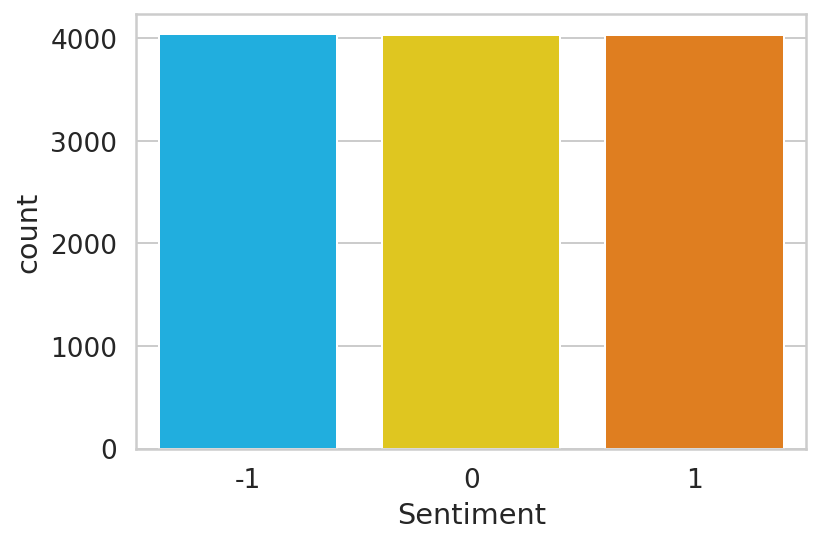

In [5]:
sns.countplot(df_train.label)
plt.xlabel('Sentiment')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Sentiment')

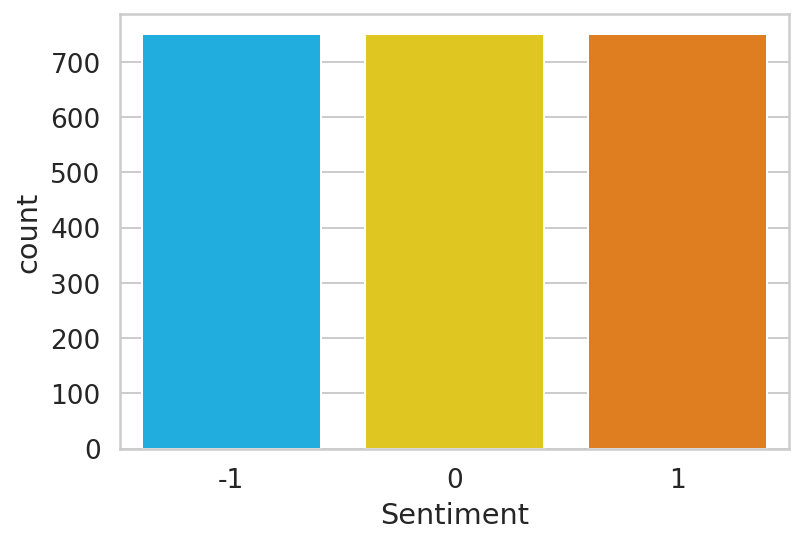

In [6]:
sns.countplot(df_test.label)
plt.xlabel('Sentiment')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Sentiment')

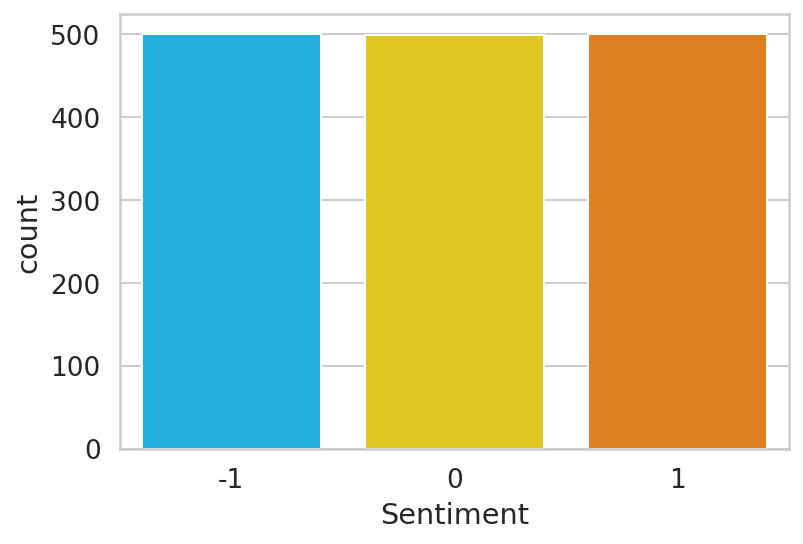

In [7]:
sns.countplot(df_valid.label)
plt.xlabel('Sentiment')

In [8]:
pd.set_option("display.max_colwidth", -1)
df_train.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,tweet,label,tuned_tweet
0,ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे वृत्त दु:खद आहे. चार दशकं त्यांनी आपल्या परखड लेखणीने पत्रकारितेत अमूल्य योगदान दिले. दीक्षित यांच्या मार्गदर्शनाखाली पत्रकारांची पिढी घडली. अनंत दीक्षित यांना भावपूर्ण श्रद्धांजली! \nआम्ही त्यांच्या परिवाराच्या दु:खात सहभागी आहोत. pic.twitter.com/s3gnQQLtpk\n,-1,ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे वृत्त दु:खद आहे चार दशकं त्यांनी आपल्या परखड लेखणीने पत्रकारितेत अमूल्य योगदान दिले दीक्षित यांच्या मार्गदर्शनाखाली पत्रकारांची पिढी घडली अनंत दीक्षित यांना भावपूर्ण श्रद्धांजली आम्ही त्यांच्या परिवाराच्या दु:खात सहभागी आहोत
1,सर्वोच्च न्यायालयाचे निर्देश डावलून पुणे पोलिसांनी प्रा. आनंद तेलतुंबडेंना अटक केली मात्र न्यायालयाने त्यांची अटक बेकायदेशीर ठरवून सरकारला जोरदार चपराक लगावली आहे. कायदा हातात घेणा-या पोलीस अधिका-यांवर तात्काळ कारवाई केली पाहिजे.\n#AnandTeltumbde\n,-1,सर्वोच्च न्यायालयाचे निर्देश डावलून पुणे पोलिसांनी प्रा आनंद तेलतुंबडेंना अटक केली मात्र न्यायालयाने त्यांची अटक बेकायदेशीर ठरवून सरकारला जोरदार चपराक लगावली आहे कायदा हातात घेणा-या पोलीस अधिका-यांवर तात्काळ कारवाई केली पाहिजे AnandTeltumbde
2,उद्धव ठाकरेंनी भाजपासोबत युती करून शिवसैनिकांचा अवमान व विश्वासघात केला आहे फसवणूक झालेल्या शिवसैनिकांबद्दल मला सहानुभूती असून स्वार्थासाठी उद्धव ठाकरे भाजपसोबत गेले तरी मोदींचे सरकार घालवण्यातच महाराष्ट्राचे हित आहे हे जाणणारे शिवसैनिक मोदींच्या विरोधात काँग्रेसला मतदान करतील\n,-1,उद्धव ठाकरेंनी भाजपासोबत युती करून शिवसैनिकांचा अवमान व विश्वासघात केला आहे फसवणूक झालेल्या शिवसैनिकांबद्दल मला सहानुभूती असून स्वार्थासाठी उद्धव ठाकरे भाजपसोबत गेले तरी मोदींचे सरकार घालवण्यातच महाराष्ट्राचे हित आहे हे जाणणारे शिवसैनिक मोदींच्या विरोधात काँग्रेसला मतदान करतील
3,"आपला समाज खूप मोठा आहे. त्यात अनेक घटक अंतर्भूत आहेत. यातील दिव्यांग हा एक घटक, जो शारीरिकदृष्ट्या कमकुवत आहे, त्याच्याकडे समाजाचे दुर्लक्ष होतेय. त्यामुळे सरकारने अशा व्यक्तींसाठी उपक्रम राबवून त्यांना समाजात सन्मानाने जगता येईल, याकडे लक्ष देण्याची गरज आहे. pic.twitter.com/g0tbJyyTPX\n",1,"आपला समाज खूप मोठा आहे त्यात अनेक घटक अंतर्भूत आहेत यातील दिव्यांग हा एक घटक, जो शारीरिकदृष्ट्या कमकुवत आहे, त्याच्याकडे समाजाचे दुर्लक्ष होतेय त्यामुळे सरकारने अशा व्यक्तींसाठी उपक्रम राबवून त्यांना समाजात सन्मानाने जगता येईल, याकडे लक्ष देण्याची गरज आहे"
4,बलात्काराचा बदला बलात्काराने घेतला पाहिजे हे म्हणणारे सावरकर आम्हाला मान्य नाहीत. द्वेष आणि तिरस्कार हिंदू धर्मातही अभिप्रेत कधीच नव्हता. आम्ही सावरकरांच्या विचारांचा विरोध करताच राहू त्यात व्यक्तीद्वेष नाही तर वैचारिक विरोध आहे. हा देश गांधींच्या विचारांनीच चालेल!\n,-1,बलात्काराचा बदला बलात्काराने घेतला पाहिजे हे म्हणणारे सावरकर आम्हाला मान्य नाहीत द्वेष आणि तिरस्कार हिंदू धर्मातही अभिप्रेत कधीच नव्हता आम्ही सावरकरांच्या विचारांचा विरोध करताच राहू त्यात व्यक्तीद्वेष नाही तर वैचारिक विरोध आहे हा देश गांधींच्या विचारांनीच चालेल
5,जरी मी देशाच्या सेवेत मृत्यू पावली तरी मला त्याचा अभिमान वाटेल..माझ्या रक्ताचे प्रत्येक थेंब या राष्ट्राच्या विकासास हातभार लावेल आणि ते मजबूत व गतिमान बनवेल-श्रीमती इंदिरा गांधी\n\nस्वतंत्र भारताच्या पहिल्या महिला पंतप्रधान इंदिरा गांधी यांना विनम्र अभिवादन !\n#IndiraGandhi pic.twitter.com/JDZ3mDqBeO\n,1,जरी मी देशाच्या सेवेत मृत्यू पावली तरी मला त्याचा अभिमान वाटेल माझ्या रक्ताचे प्रत्येक थेंब या राष्ट्राच्या विकासास हातभार लावेल आणि ते मजबूत व गतिमान बनवेल-श्रीमती इंदिरा गांधी स्वतंत्र भारताच्या पहिल्या महिला पंतप्रधान इंदिरा गांधी यांना विनम्र अभिवादन IndiraGandhi
6,"आज, बारामती शहर परिसरात सुरु असणाऱ्या विविध विकास कामांना प्रत्यक्ष भेटी देत कामाचा आढावा घेतला. शहरासह तालुक्यातील कायदा-सुव्यवस्था सुरळीत राखण्यासाठी अवैध व्यवसाय करणाऱ्यांवर कडक कारवाई करण्याचे निर्देश दिले. pic.twitter.com/WJCsuaQ52M\n",1,"आज, बारामती शहर परिसरात सुरु असणाऱ्या विविध विकास कामांना प्रत्यक्ष भेटी देत कामाचा आढावा घेतला शहरासह तालुक्यातील कायदा-सुव्यवस्था सुरळीत राखण्यासाठी अवैध व्यवसाय करणाऱ्यांवर कडक कारवाई करण्याचे निर्देश दिले"
7,@INCMaharashtra च्या माजी अध्यक्ष स्व. प्रभाताई राव यांना जयंतीनिमित्त विनम्र अभिवादन! pic.twitter.com/Ztvgy1nvxt\n,1,च्या माजी अध्यक्ष स्व प्रभाताई राव यांना जयंतीनिमित्त विनम्र अभिवादन
8,"पालखी सोहळ्यात अपघात 

# Preprocessing with transformers

In [ ]:
PRE_TRAINED_MODEL_NAME = 'google/muril-base-cased'

In [ ]:
muril_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'मेरी आणि सामंथा बस स्थानकावर लवकर पोहोचल्या पण दुपारपर्यंत बसची वाट पाहत बसले'

In [ ]:


tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')



In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

In [ ]:


encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32, # Max no. of tokens 
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()



In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids']

In [ ]:
print(len(encoding['token_type_ids'][0]))
encoding['token_type_ids']

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [ ]:
token_lens = []
for txt in tqdm(df_train.tuned_tweet):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

100%|██████████| 12109/12109 [00:07<00:00, 1700.61it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


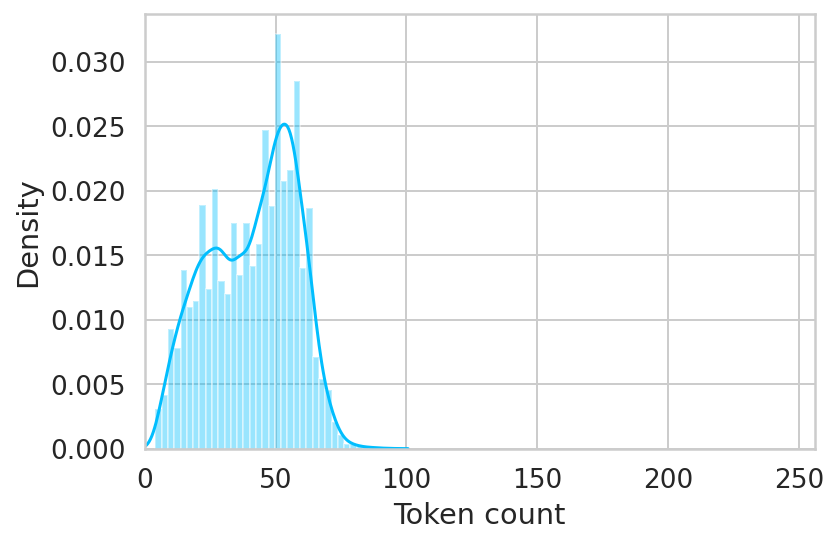

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
plt.show()

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      return_attention_mask=True,
      padding= 'max_length',
      # pad_to_max_length = True,
      return_tensors='pt',
    )

    return {
      'tweet_text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'type_ids': encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train.shape, df_valid.shape, df_test.shape

((12109, 3), (1499, 3), (2250, 3))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df.tuned_tweet.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'type_ids', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Classification

In [ ]:
print(encoding['attention_mask'] , encoding['token_type_ids'])

In [ ]:
x = muril_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  token_type_ids=encoding['token_type_ids']
)

In [ ]:
print(x['last_hidden_state'].shape, x['pooler_output'].shape)

In [ ]:
muril_model.config.hidden_size

In [ ]:

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes, base):
    super(SentimentClassifier, self).__init__()
    self.muril = base
    self.drop1 = nn.Dropout(p=0.3)
    self.lstm = nn.LSTM(base.config.hidden_size, 150,bidirectional=True,dropout=0.2)
    self.out1 = nn.Linear(300,64)
    self.relu = nn.ReLU()
    self.drop2 = nn.Dropout(p=0.1) 
    self.out = nn.Linear(64, n_classes)
  
  def forward(self, input_ids, attention_mask, token_type_ids):
    x = self.muril(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    pooled_output = x['pooler_output']
    output = self.drop1(pooled_output)
    output = output.view(len(output), 1, -1)
    output, _ = self.lstm(output)
    output = output.view(len(output), output.shape[-1])
    output =self.relu(self.out1(output))
    output = self.drop2(output)
    return self.out(output)

In [ ]:

class_names = ['-1','0', '1']
model = SentimentClassifier(len(class_names), muril_model)
model = model.to(device)

In [ ]:
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'type_ids', 'targets'])

In [ ]:

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['type_ids'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(token_type_ids.shape) # batch size x seq_length

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
data

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[   104,  17857,   8096,  ...,      0,      0,      0],
         [   104,   8385, 120210,  ...,      0,      0,      0],
         [   104,  80460,  31017,  ...,      0,      0,      0],
         ...,
         [   104,   4842,   3274,  ...,      0,      0,      0],
         [   104, 104023,   1373,  ...,      0,      0,      0],
         [   104,    100,   1680,  ...,      0,      0,      0]]),
 'targets': tensor([-1, -1, -1,  1, -1,  1,  1,  1, -1,  0, -1, -1, -1, -1,  1,  0]),
 'tweet_text': ['ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे वृत्त दु:खद आहे चार दशकं त्यांनी आपल्या परखड लेखणीने पत्रकारितेत अमूल्य योगदान दिले दीक्षित यांच्या मार्गदर्शनाखाली पत्रकारांची पिढी घडली अनंत दीक्षित यांना भावपूर्ण श्रद्धांजली आम्ही त्यां

In [ ]:
input_ids

tensor([[   104,  17857,   8096,  ...,      0,      0,      0],
        [   104,   8385, 120210,  ...,      0,      0,      0],
        [   104,  80460,  31017,  ...,      0,      0,      0],
        ...,
        [   104,   4842,   3274,  ...,      0,      0,      0],
        [   104, 104023,   1373,  ...,      0,      0,      0],
        [   104,    100,   1680,  ...,      0,      0,      0]],
       device='cuda:0')

In [ ]:
model(input_ids, attention_mask, token_type_ids)

tensor([[ 0.0636, -0.0958, -0.0917],
        [ 0.0677, -0.0912, -0.0942],
        [ 0.0581, -0.0963, -0.0944],
        [ 0.0669, -0.0905, -0.0974],
        [ 0.0545, -0.0832, -0.0897],
        [ 0.0599, -0.0980, -0.0969],
        [ 0.0684, -0.0864, -0.0951],
        [ 0.0511, -0.0947, -0.0991],
        [ 0.0554, -0.0961, -0.0974],
        [ 0.0594, -0.0908, -0.0891],
        [ 0.0677, -0.0945, -0.1015],
        [ 0.0537, -0.0921, -0.0944],
        [ 0.0618, -0.0953, -0.0950],
        [ 0.0611, -0.0899, -0.0908],
        [ 0.0627, -0.0927, -0.0955],
        [ 0.0653, -0.0940, -0.0981]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
F.softmax(model(input_ids, attention_mask, token_type_ids), dim=1)

tensor([[0.3717, 0.3132, 0.3150],
        [0.3691, 0.3145, 0.3165],
        [0.3683, 0.3165, 0.3152],
        [0.3672, 0.3164, 0.3164],
        [0.3685, 0.3158, 0.3158],
        [0.3689, 0.3154, 0.3157],
        [0.3701, 0.3152, 0.3148],
        [0.3707, 0.3146, 0.3147],
        [0.3694, 0.3152, 0.3154],
        [0.3691, 0.3159, 0.3150],
        [0.3689, 0.3157, 0.3154],
        [0.3693, 0.3169, 0.3139],
        [0.3693, 0.3148, 0.3159],
        [0.3682, 0.3171, 0.3148],
        [0.3690, 0.3148, 0.3162],
        [0.3671, 0.3171, 0.3158]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d['type_ids'].to(device)
    targets = d["targets"].to(device)
    targets+=1

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )

    _, preds = torch.max(outputs, dim=1)
  
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)
      targets+=1

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids

      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'\n--> Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_valid)
  )

  print(f'--> Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'muril_bilstm_model_state.bin')
    best_accuracy = val_acc


# Results

In [ ]:
for i in range(len(history["train_acc"])):
  history["train_acc"][i]=history["train_acc"][i].cpu() 

In [ ]:
for i in range(len(history["val_acc"])):
  history["val_acc"][i]=history["val_acc"][i].cpu()  

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([.8, 1]);

# Evaluation

In [ ]:
model2 = SentimentClassifier(len(class_names), muril_model)
model2.load_state_dict(torch.load('muril_bilstm_model_state.bin'))
model2.eval()

In [ ]:
model2 = model2.to(device)

In [ ]:
test_acc, _ = eval_model(
  model2,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8404444444444444

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d['type_ids'].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids = token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [ ]:

y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
y_pred-=1

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          -1       0.87      0.89      0.88       750
           0       0.78      0.82      0.80       750
           1       0.87      0.80      0.83       750

    accuracy                           0.84      2250
   macro avg       0.84      0.84      0.84      2250
weighted avg       0.84      0.84      0.84      2250



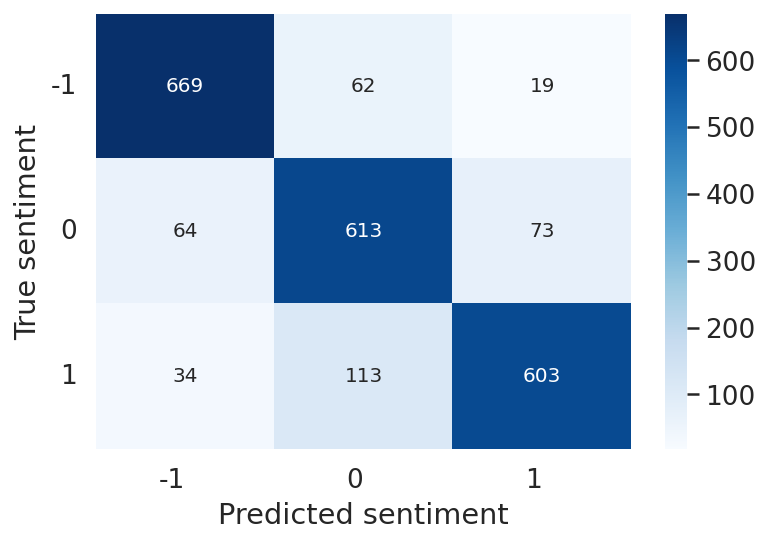

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
y_test[50:60]

In [ ]:
idx = 50

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})



 आमचे मार्गदर्शक, अहमदनगर शहराचे माजी महापौर व माजी नगराध्यक्ष दीप चव्हाण साहेबांना वाढदिवसाच्या मनःपूर्वक शुभेच्छा 




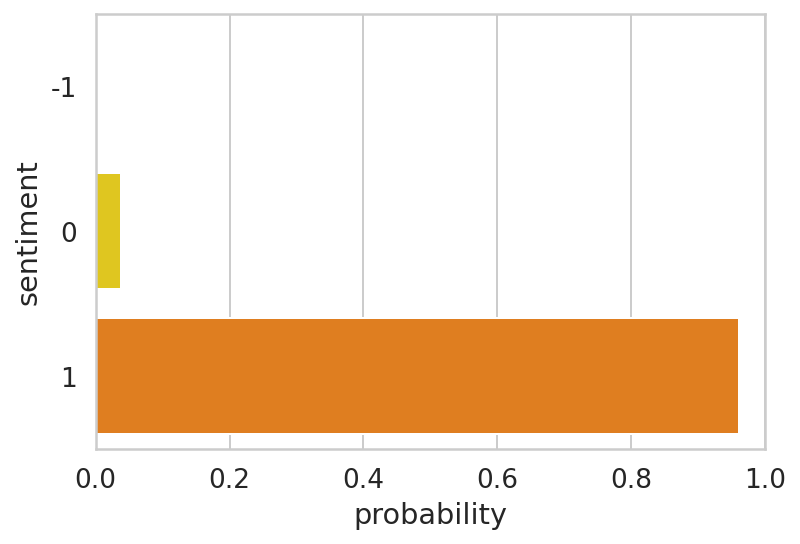

In [ ]:
print('\n\n',tweet_text, '\n\n')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
y_test[14], y_tweet_texts[14]

# Custom Prediction

In [ ]:
# strip -> punctuations  -> @ mentions delete -> url delete ->  remove # from #-tokens -> stop words delete (no delete )  -> rare words no delete)
def preprocess(line):

  line = line.strip()
  line = re.sub(r'\S*\.com\S*'," ",line)
  line = re.sub(r'\S*\.in\S*'," ",line)
  line = re.sub(r'\S*\.net\S*'," ",line)
  line = re.sub(r'\S*\.me\S*'," ",line)
  line = re.sub(r'\s+:\s+'," ",line)
  line = re.sub(r'\s+-\s+'," ",line)
  
  
  line = re.sub(r'/https?\/\/(.*\.(in))\//'," ",line)
  line = re.split(r'\s+|[!$%&()*+./;<=>?\^`{|}~\'\"]\s*', line)
  line = [token.strip() for token in line if token != '' and token != ' ' and token != '\n']
  
  if len(line) > 1:
    tokens = []
    for i in range(len(line)):
      if line[i][0] == '#':
        tokens.append(line[i][1:])
      elif line[i][0] == '@' or line[i][0] in string.punctuation :
        continue
      else:
        tokens.append(line[i])
    return tokens


In [ ]:
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "प्रौढ प्रताप पुरंदर, क्षत्रिय कुलावतंस, सिंहासनाधीश्वर, महाराजाधिराज महाराज श्रीमंत श्री छत्रपती शिवाजी महाराज की जय"
tweet_text = "मनाचे वेधना किती सोसावे सामान्य माणसाने"
tweet_text = "माननीय महोदय संजय विचारे यांच्या अपघाताची बातमी आज कळाली. खूप वाईट वाटले."
tweet_text = "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "गढ आला पण माझा सिंह गेला"
tweet_text = "मैदानात हजारो कंडोम पाकीटं कुणी फेकली?; खुलासा होताच अधिकाऱ्यांनी डोक्यावर हात मारला"
tweet_text = "महाशिवरात्रीच्या सर्वांना हार्दिक हार्दिक शुभेच्छा"
tweet_text= "नमो सरकारला साधी अडचने पार पाडण्याची बुद्धी नाही आहे. एकदम मूर्खपणाचे लक्षण आहे"
tweet_text = "हिंदू धर्मात मुलांना लहानपणापासून आपला धर्मग्रंथ गीता शिकवला जात नाही हे सत्य आहे."
tweet_text = "प्रा. यारकुंडकरांसारख्या थोर वयकतीमत्वाचा परिचय देताना, मला आज प्रचंड अभिमान वाटतोय."
tweet_text = preprocess(tweet_text)
tweet_text = " ".join(tweet_text)

In [ ]:

encoded_tweet = tokenizer.encode_plus(
  tweet_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)


In [ ]:
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
token_type_ids = encoded_tweet['token_type_ids'].to(device)

output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)

print(f'Tweet text: {tweet_text}')
print(f'Sarcasm  : {class_names[prediction]}')

Tweet text: प्रा यारकुंडकरांसारख्या थोर वयकतीमत्वाचा परिचय देताना, मला आज प्रचंड अभिमान वाटतोय
Sarcasm  : 1
